In [ ]:
import os
import json
import requests
import pandas as pd


"""
Project Title: Institutional Ownership and Urban Housing Markets — LA • NYC • Miami • Philadelphia

API's used: ATTOM API, American Bureau Census API, Redfin Databank (CSV download)

@authors: Lola Serdan, Lucas Lee, Antonio Vieira




Our prompting of the ATTOM API is done via one main function: try_salestrend_city that allows to chose the interval
## (yearly/quarter), city_name, start, and end.
## This function takes a string name of the desired city, parses through the ATTOM API to find the geo1dV4 library to find the key that matches the inputted city
## The geoIdV4 is an ATTOM proprietary encryption key that is used to identify cities
## We then use the obtained geoIdV4 keys to lookup data about real estate sales trend in that specific area.
## To do this we use the ATTOM http under salestrend (check SALESTREND_URL)
## The function sets default parameters for the goal of this investigation, however some fields can be overriden like interval (quarterly/yearly), start, end

## Note: The function is subdivided into 3 key functionalities:

(A) Lookup the geoIdV4 key
The expected city_name format is name, state, as is default in ATTOM
It uses the URL under Location Lookup -> see https://cloud-help.attomdata.com/article/579-geocodes
Limitation: ATTOM’s geoIdV4 for Postal City (CI) splits municipalities into sub-areas
However, we aggregate say "New Philadelphia, PA", "Philadelphia, PA" as the same city


(B) Uses the CI to fetch the geoIdV4 code
With this code fetched, it is pretty straightforward to fetch the salestrend data
All we do is set the desired interval, start, end, and use the requests.get to fetch the data.
Some cautionary measures are done to avoid the program from crashing and exiting
Say if we don't find data on some city, we catch that error and print out: No data on {city_name}

(C) We normalize the fetched data by:
Renaming columns
Sets year to numeric type in preparation for a time-series
Finally, the function returns a dataframe for each queried city, which may include more than one Postal City.
Along the sales trend data in a historical fashion.

"""

API_KEY = '916024e203c73a2073e6c4b2453b1204'
LOOKUP_URL = "https://api.gateway.attomdata.com/v4/location/lookup"
SALESTREND_URL = "https://api.gateway.attomdata.com/v4/transaction/salestrend"

def try_salestrend_city(city_name: str,
                        interval: str = "yearly",
                        start: str = "2018",
                        end: str = "2025",
                        start_q: str = "01", end_q: str = "04",
                        start_m: str = "01", end_m: str = "12") -> pd.DataFrame | None:

    headers = {"accept": "application/json", "apikey": API_KEY}

    # ---- (A) Look up the postal city (CI) geoIdV4
    look_params = {"geographyTypeAbbreviation": "CI", "name": city_name}
    r_lookup = requests.get(LOOKUP_URL, headers=headers, params=look_params, timeout=30)
    print("Lookup HTTP:", r_lookup.status_code)
    try:
        lookup_payload = r_lookup.json()
    except ValueError:
        print("Lookup returned non-JSON. Snippet:", r_lookup.text[:800])
        return None

    status = lookup_payload.get("status", {})
    print("Lookup status:", json.dumps(status, indent=2))
    geos = lookup_payload.get("geographies", []) or []
    if not geos:
        print(f"No postal city matches for '{city_name}'.")
        return None

    # collect all CI geos whose geographyName CONTAINS the input text (case-insensitive)
    q = city_name.strip().lower()
    targets = [g for g in geos if q in str(g.get("geographyName", "")).strip().lower()]
    if not targets:
        #
        targets = [geos[0]]

    print("Matched postal cities (contains):", [t.get("geographyName") for t in targets])

    all_rows = []

    # ---- (B) Build Sales Trend request with interval-aware params, for EACH matched CI geo
    for target in targets:
        geo_id_v4 = target.get("geoIdV4")
        geo_label = target.get("geographyName")
        if not geo_id_v4:
            print(f"Skipping '{geo_label}' — missing geoIdV4.")
            continue

        params = {"geoIdV4": geo_id_v4, "interval": interval, "startyear": start, "endyear": end}
        if interval == "quarterly":
            params["startquarter"] = start_q
            params["endquarter"] = end_q
        elif interval == "monthly":
            params["startmonth"] = start_m
            params["endmonth"] = end_m

        r_sales = requests.get(SALESTREND_URL, headers=headers, params=params, timeout=30)
        print(f"SalesTrend HTTP ({geo_label}):", r_sales.status_code)
        try:
            sales_payload = r_sales.json()
        except ValueError:
            print("SalesTrend returned non-JSON. Snippet:", r_sales.text[:800])
            continue

        st_status = sales_payload.get("status") or sales_payload.get("Response", {}).get("status", {})
        print("SalesTrend status:", json.dumps(st_status, indent=2))
        ok = (r_sales.status_code == 200) and (str(st_status.get("code")) in ("0", "200"))
        rows = sales_payload.get("salesTrends") or sales_payload.get("response", {}).get("result", {}).get("salestrend")
        if ok and rows:
            # keep each component separate by leaving its own location/geographyName in place
            all_rows.extend(rows)
        else:
            print(f"No sales trend rows for '{geo_label}'.")

    if not all_rows:
        print("No sales trend rows returned for any matched CI.")
        return None

    # ---- (C) Normalize → DataFrame
    df = pd.json_normalize(all_rows, sep=".")
    df = df.rename(columns={
        "location.geoIdV4": "geoIdV4",
        "location.geographyName": "geographyName",
        "dateRange.interval": "interval",
        "dateRange.start": "start",
        "dateRange.end": "end",
        "salesTrend.homeSaleCount": "homeSaleCount",
        "salesTrend.avgSalePrice": "avgSalePrice",
        "salesTrend.medSalePrice": "medSalePrice",
        "vintage.pubDate": "pubDate",
    })
    # Add numeric year for yearly pulls (handy later)
    if "interval" in df.columns and (df["interval"] == "yearly").any() and "start" in df.columns:
        df["year"] = pd.to_numeric(df["start"], errors="coerce")

    # Tag which city we queried (nice for merges)
    df["queriedCity"] = city_name
    return df

In [ ]:
import requests, pandas as pd

## Query 2: American Census Bureau --> Fetching data on city's population and residence counts
## The objective of this second query is to bring more information to our city's real estate sales price.
## More specifically, we are aiming to cross-reference data from the ATTOM API's dataframe about salestrends with the American Census API, which is free and easy to use
## This will leave us with a more granular and informative perspective of each city and its real estate market in the form of a time-series
## We choose the census api as it allows us to trace historical population, residence unit counts, single family units, and multi-family units
## The ultimate goal is to bring more data points to the real estate data from our 3 desired cities: Boston, NY, and LA
## With this information brought in via a left join, we can not only track price movements in real estate but also a more concrete health meter of the real estate market



CENSUS_BASE = "https://api.census.gov/data"

## The next steps are necessary in order to properly access the data in the census api
## see: https://www.census.gov/data/developers/data-sets/acs-1year.html
## This first function in particular is ensuring we grab the correct time interval for our data, as the census bureau releases it in all sorts of intervals
## 1-year, 3-years, 5-years, 10-years.

def _acs_dataset_for_year(city_pop_estimate, year):

    return "acs/acs1" if city_pop_estimate and city_pop_estimate >= 65000 else "acs/acs5"

def fetch_acs_place_timeseries(city_name: str,
                               years: list[int],
                               api_key: str | None = None,
                               assume_big_city: bool = True) -> pd.DataFrame:

    city, st_abbr = [s.strip() for s in city_name.split(",")]
    st_fips = STATE_ABBR_TO_FIPS[st_abbr]
    st_full = STATE_ABBR_TO_NAME[st_abbr]

    # Variables we want (detailed tables)
    # source: https://www.census.gov/data/developers/guidance/api-user-guide.Core_Concepts.html
    vars_ = [
        "B01003_001E",  # population
        "B25024_001E",  # total housing units
        "B25024_002E",  # 1-detached
        "B25024_003E",  # 1-attached
        "B25024_004E","B25024_005E","B25024_006E","B25024_007E","B25024_008E","B25024_009E"
    ]

    rows = []
    # big cities use ACS 1-year; if it fails, use the 5 year interval (although our queried cities are big cities, this is standard when dealing with the Census API)
    datasets_for_year = {}
    for yr in years:
        ds_guess = "acs/acs1" if assume_big_city else "acs/acs5"
        for ds in [ds_guess, "acs/acs5"] if ds_guess == "acs/acs1" else ["acs/acs5"]:
            params = {
                "get": "NAME," + ",".join(vars_),
                "for": "place:*",
                "in": f"state:{st_fips}"
            }
            if api_key:
                params["key"] = api_key
            url = f"{CENSUS_BASE}/{yr}/{ds}"
            r = requests.get(url, params=params, timeout=30)
            if r.status_code != 200:
                continue
            data = r.json()
            cols = data[0]
            recs = [dict(zip(cols, row)) for row in data[1:]]
            # Target NAME forms we accept (prefer exact 'city')
            targets = {
                f"{city} city, {st_full}",
                f"{city} CDP, {st_full}",
                f"{city} town, {st_full}",  # some New England places are "town"
                f"{city}, {st_full}"        # occasional plain label
            }
            match = next((d for d in recs if d.get("NAME") in targets), None)
            if match:
                match["__dataset__"] = ds  # record which ACS flavor succeeded
                match["__year__"] = yr
                rows.append(match)
                datasets_for_year[yr] = ds
                break  # stop trying other datasets for this year

    if not rows:
        return pd.DataFrame(columns=[
            "queriedCity","year","acs_population","acs_total_units","acs_sf_units","acs_mf_units",
            "place_geoid","ACS_dataset"
        ])

    df = pd.DataFrame(rows)
    # Cast to numeric
    for c in vars_:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    # We have to calculate the number of single-family and multi-family units.
    # Here we also rename the columns for better readability and data identification
    df["acs_total_units"] = df["B25024_001E"]
    df["acs_sf_units"]    = df["B25024_002E"] + df["B25024_003E"]
    df["acs_mf_units"]    = df[["B25024_004E","B25024_005E","B25024_006E","B25024_007E","B25024_008E","B25024_009E"]].sum(axis=1)
    df["acs_population"]  = df["B01003_001E"]
    df["year"]            = df["__year__"]
    df["place_geoid"]     = df["state"] + df["place"]
    df["ACS_dataset"]     = df["__dataset__"]
    df["queriedCity"]     = city_name

    desired = ["queriedCity","year","acs_population","acs_total_units","acs_sf_units","acs_mf_units",
            "place_geoid","ACS_dataset","NAME"]
    return df[desired].sort_values(["year"])

## This function joins the two final dataFrames: the ATTOM API query and the the ACS query
## This will allow us to append extra columns to each city and its time interval
## The left-join will leave us with say: "Boston, 2018": population, avg_house_salesprice, total residence units

def merge_sales_with_acs(df_sales: pd.DataFrame, df_acs: pd.DataFrame) -> pd.DataFrame:
    # Ensure df_sales.year exists
    if "year" not in df_sales.columns:
        # ATTOM start is typically "YYYY" (yearly) or ISO-like date for sub-year; coerce
        df_sales = df_sales.copy()
        df_sales["year"] = pd.to_numeric(df_sales["start"].str[:4], errors="coerce")

    df_out = df_sales.merge(df_acs, on=["queriedCity","year"], how="left")
    return df_out

In [ ]:
# Steps #
# 1) Use try_salestrend_city to fetch data from the ATTOM API
# 2) Get data from the free Census API
# 3) Use merge_sales_with_acs to join the ATTOM Data with the Census Data

# ----- CREATE THE DATA FRAMES FOR EACH CITY ----- #
CENSUS_API_KEY = None

# 1) Philadelphia, PA
df_pa = try_salestrend_city("Philadelphia, PA", interval="yearly", start="2018", end="2025")
df_pa['geographyName'] = 'Philadelphia, PA'


df_census_pa = fetch_acs_place_timeseries("Philadelphia, PA", years=list(range(2018, 2025)),
                                        api_key=CENSUS_API_KEY, assume_big_city=True)

df_pa_enriched = merge_sales_with_acs(df_pa, df_census_pa)

# 2) New York, NY
df_ny = try_salestrend_city("New York, NY", interval="yearly", start="2018", end="2025")

df_census_ny = fetch_acs_place_timeseries("New York, NY", years=list(range(2018, 2025)),
                                        api_key=CENSUS_API_KEY, assume_big_city=True)

df_ny_enriched = merge_sales_with_acs(df_ny, df_census_ny)


# 3) Miami, FL
df_mia = try_salestrend_city("Miami, FL", interval="yearly", start="2018", end="2025")
df_census_mia = fetch_acs_place_timeseries("Miami, FL", years=list(range(2018, 2025)),
                                        api_key=CENSUS_API_KEY, assume_big_city=True)

df_mia_enriched = merge_sales_with_acs(df_mia, df_census_mia)

# 4) Los Angeles, CA
df_la = try_salestrend_city("Los Angeles, CA", interval="yearly", start="2018", end="2025")

df_census_la = fetch_acs_place_timeseries("Los Angeles, CA", years=list(range(2018, 2025)),
                                        api_key=CENSUS_API_KEY, assume_big_city=True)

df_la_enriched = merge_sales_with_acs(df_la, df_census_la)

Lookup HTTP: 200
Lookup status: {
  "version": "4",
  "code": 0,
  "msg": "SuccessWithResult",
  "total": 2,
  "page": 1,
  "pageSize": 10,
  "transactionID": "cacca2e8c4c2286eedaea07de2161d5f"
}
Matched postal cities (contains): ['Philadelphia, PA', 'New Philadelphia, PA']
SalesTrend HTTP (Philadelphia, PA): 200
SalesTrend status: {
  "version": "4",
  "code": 0,
  "msg": "SuccessWithResult",
  "total": 8,
  "page": 1,
  "pageSize": 100,
  "transactionID": "cacca2e8c4c2286eedaea07de2161d5f"
}
SalesTrend HTTP (New Philadelphia, PA): 200
SalesTrend status: {
  "version": "4",
  "code": 0,
  "msg": "SuccessWithResult",
  "total": 8,
  "page": 1,
  "pageSize": 100,
  "transactionID": "49459a850c70442caadc0fc0e7ed0fea"
}
Lookup HTTP: 200
Lookup status: {
  "version": "4",
  "code": 0,
  "msg": "SuccessWithResult",
  "total": 1,
  "page": 1,
  "pageSize": 10,
  "transactionID": "9b0b2a3b0bc190c6eecbeacf2d586ec5"
}
Matched postal cities (contains): ['New York, NY']
SalesTrend HTTP (New York,

In [ ]:
import pandas as pd

def redfin_ims_by_year(csv_path: str, city: str) -> pd.DataFrame:
    try:
        rf = pd.read_csv(csv_path, encoding="utf-16", sep="\t")
    except Exception:
        rf = pd.read_csv(csv_path)  # fallback if it’s a plain CSV

    # Keep just the city + needed cols
    df = rf.loc[rf["Redfin Metro"].astype(str).eq(city),
                ["Quarter", "Redfin Metro", "Investor Market Share"]].copy()

    # Year from strings like "2000 Q1"
    df["year"] = df["Quarter"].astype(str).str.extract(r"(\d{4})").astype(int)

    # Clean percentages
    df["Investor Market Share"] = pd.to_numeric(
        df["Investor Market Share"].astype(str).str.rstrip("%"), errors="coerce"
    )

    # Annualize: simple mean of the four quarters
    out = (df.groupby("year", as_index=False)["Investor Market Share"].mean()
             .round(2))
    out.insert(1, "city", city)
    return out[["year", "city", "Investor Market Share"]]


In [ ]:
csv_path = "/dowload_investor_purchases_by_metro.csv"

la_ims = redfin_ims_by_year(csv_path, "Los Angeles, CA")
la_redfin = la_ims[la_ims['year']>=2018]

print(la_redfin)

ny_ims = redfin_ims_by_year(csv_path, "New York, NY")
ny_redfin = ny_ims[ny_ims['year']>=2018]

print(ny_redfin)

mia_ims = redfin_ims_by_year(csv_path, "Miami, FL")
mia_redfin = mia_ims[mia_ims['year']>=2018]

print(mia_redfin)

phi_ims = redfin_ims_by_year(csv_path, "Philadelphia, PA")
phi_redfin = phi_ims[phi_ims['year']>=2018]

print(phi_redfin)

    year             city  Investor Market Share
18  2018  Los Angeles, CA                  18.00
19  2019  Los Angeles, CA                  17.25
20  2020  Los Angeles, CA                  16.25
21  2021  Los Angeles, CA                  18.00
22  2022  Los Angeles, CA                  20.25
23  2023  Los Angeles, CA                  20.50
24  2024  Los Angeles, CA                  21.25
25  2025  Los Angeles, CA                  24.50
    year          city  Investor Market Share
18  2018  New York, NY                  17.75
19  2019  New York, NY                  17.00
20  2020  New York, NY                  14.25
21  2021  New York, NY                  13.50
22  2022  New York, NY                  17.25
23  2023  New York, NY                  19.00
24  2024  New York, NY                  19.00
25  2025  New York, NY                  21.00
    year       city  Investor Market Share
18  2018  Miami, FL                  31.25
19  2019  Miami, FL                  28.25
20  2020  Miami,

In [ ]:
# 1) tiny helper to attach Redfin share
def attach_redfin_share(enriched, redfin_yearly, city_col=None, out_col="redfin_investor_share_pct"):
    if city_col is None:
        city_col = ("geographyName" if "geographyName" in enriched.columns else
                    "queriedCity" if "queriedCity" in enriched.columns else "city")
    r = redfin_yearly.rename(columns={"city": city_col, "Investor Market Share": out_col})
    return enriched.merge(r[[city_col, "year", out_col]], on=[city_col, "year"], how="left")

# 2) do the four merges between the enriched (ATTOM + CENSUS) and the Redfin Data
df_la_final = attach_redfin_share(df_la_enriched, la_redfin)        # Los Angeles, CA
df_ny_final = attach_redfin_share(df_ny_enriched, ny_redfin)        # New York, NY
df_mia_final = attach_redfin_share(df_mia_enriched, mia_redfin)     # Miami, FL
df_pa_final = attach_redfin_share(df_pa_enriched, phi_redfin)       # Philadelphia, PA

# 3) peek
print(df_la_final[["year","geographyName", "avgSalePrice","redfin_investor_share_pct"]])

   year    geographyName  avgSalePrice  redfin_investor_share_pct
0  2018  Los Angeles, CA       1041736                      18.00
1  2019  Los Angeles, CA       1070565                      17.25
2  2020  Los Angeles, CA       1157133                      16.25
3  2021  Los Angeles, CA       1279337                      18.00
4  2022  Los Angeles, CA       1344175                      20.25
5  2023  Los Angeles, CA       1301910                      20.50
6  2024  Los Angeles, CA       1333690                      21.25
7  2025  Los Angeles, CA       1445858                      24.50


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid", context="talk")

## Mini helper function to help with conversion and helps save space
def _usd(x, pos):
    if x >= 1_000_000: return f"${x/1_000_000:.1f}M"
    if x >= 1_000:     return f"${x/1_000:.1f}K"
    return f"${int(x):,}"

## Mini helper to help with percentage for displaying purposes
def _pct(x, pos): return f"{x:.0f}%"

## This function takes in any of our 4 final dfs and displays a final dashboard consisting of 4 graphs.
def plot_city_dashboard(df: pd.DataFrame):
    d = df.rename(columns={
        "geographyName": "city",
        "acs_population": "city_pop",
        "acs_total_units": "total_units",
        "acs_sf_units": "single_units",
        "acs_mf_units": "mf_units",
        "avgSalePrice": "avg_sale_price",
        "medSalePrice": "median_sale_price",
        "homeSaleCount": "home_sales",
        "redfin_investor_share_pct": "investor_share_pct",
    }).copy()

    d = d.sort_values("year").reset_index(drop=True)
    city = d.get("city", d.get("geographyName", "City")).iloc[0]


    # ---- layout: constrained to prevent overlaps ----
    fig, axes = plt.subplots(2, 2, figsize=(15, 9), constrained_layout=True)
    fig.suptitle(f"{city}: Prices, Sales, Population & Investor Activity", fontsize=18)

    # (1) Dual-axis time series: Avg Sale Price vs Home Sales
    ax = axes[0, 0]
    sns.lineplot(data=d, x="year", y="avg_sale_price", marker="o", ax=ax, color="tab:blue")
    ax.set_xlabel("Year"); ax.set_ylabel("Average Sale Price ($)", color="tab:blue")
    ax.yaxis.set_major_formatter(FuncFormatter(_usd)); ax.tick_params(axis="y", labelcolor="tab:blue")
    ax.tick_params(axis="x", rotation=45); ax.set_title("Avg Sale Price vs Home Sale Count (Yearly)")
    ax2 = ax.twinx()
    sns.lineplot(data=d, x="year", y="home_sales", marker="o", ax=ax2, color="tab:red")
    ax2.set_ylabel("Home Sale Count", color="tab:red"); ax2.tick_params(axis="y", labelcolor="tab:red")

    # (2) Investor Share time series
    ax = axes[0, 1]
    sns.lineplot(data=d, x="year", y="investor_share_pct", marker="o", ax=ax, color="tab:green")
    ax.set_xlabel("Year"); ax.set_ylabel("Investor Market Share (%)")
    ax.yaxis.set_major_formatter(FuncFormatter(_pct))
    ax.tick_params(axis="x", rotation=45); ax.set_title("Institutional Ownership Over Time")

    # (3) Scatter: Investor Share vs Avg Sale Price
    ax = axes[1, 0]
    sns.regplot(data=d, x="investor_share_pct", y="avg_sale_price", ci=None, ax=ax)
    ax.set_xlabel("Investor Market Share (%)"); ax.set_ylabel("Average Sale Price ($)")
    ax.yaxis.set_major_formatter(FuncFormatter(_usd))
    ax.set_title("Investor Share vs Average Sale Price")

    # (4) Correlation heatmap (focused, 1 decimal)
    ax = axes[1, 1]
    cols = [c for c in ["investor_share_pct","avg_sale_price","median_sale_price",
                        "home_sales","city_pop","single_units","mf_units"] if c in d.columns]
    corr = d[cols].corr(numeric_only=True).round(1)
    sns.heatmap(corr, annot=True, fmt=".1f", vmin=-1, vmax=1, cmap="vlag", ax=ax)
    ax.set_title("Correlation (Selected Variables)")

    plt.show()
    return d

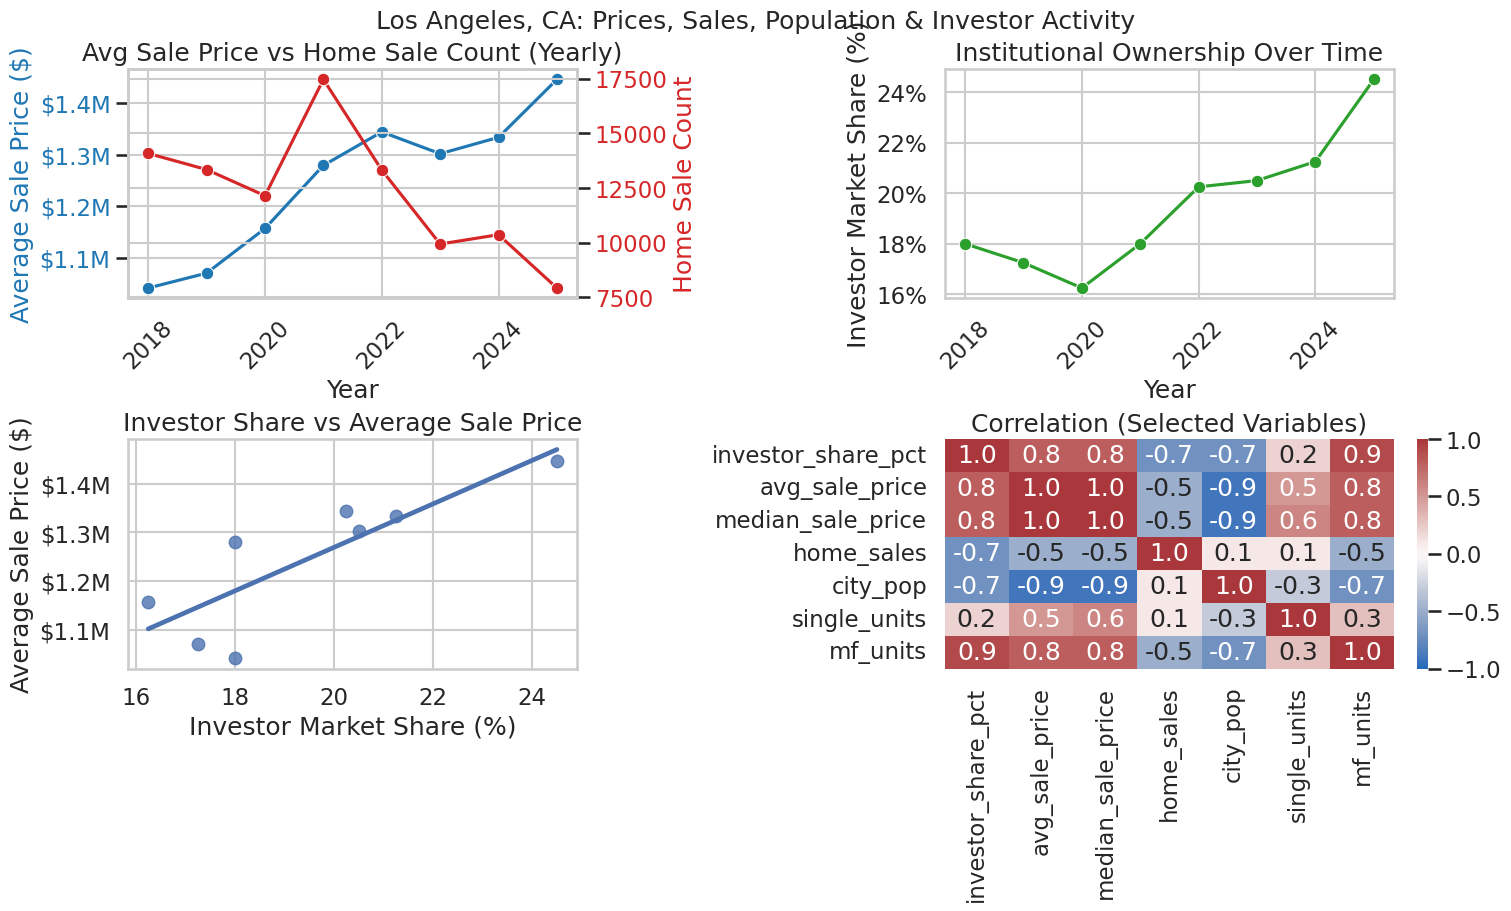

In [ ]:
_ = plot_city_dashboard(df_la_final)   # Los Angeles




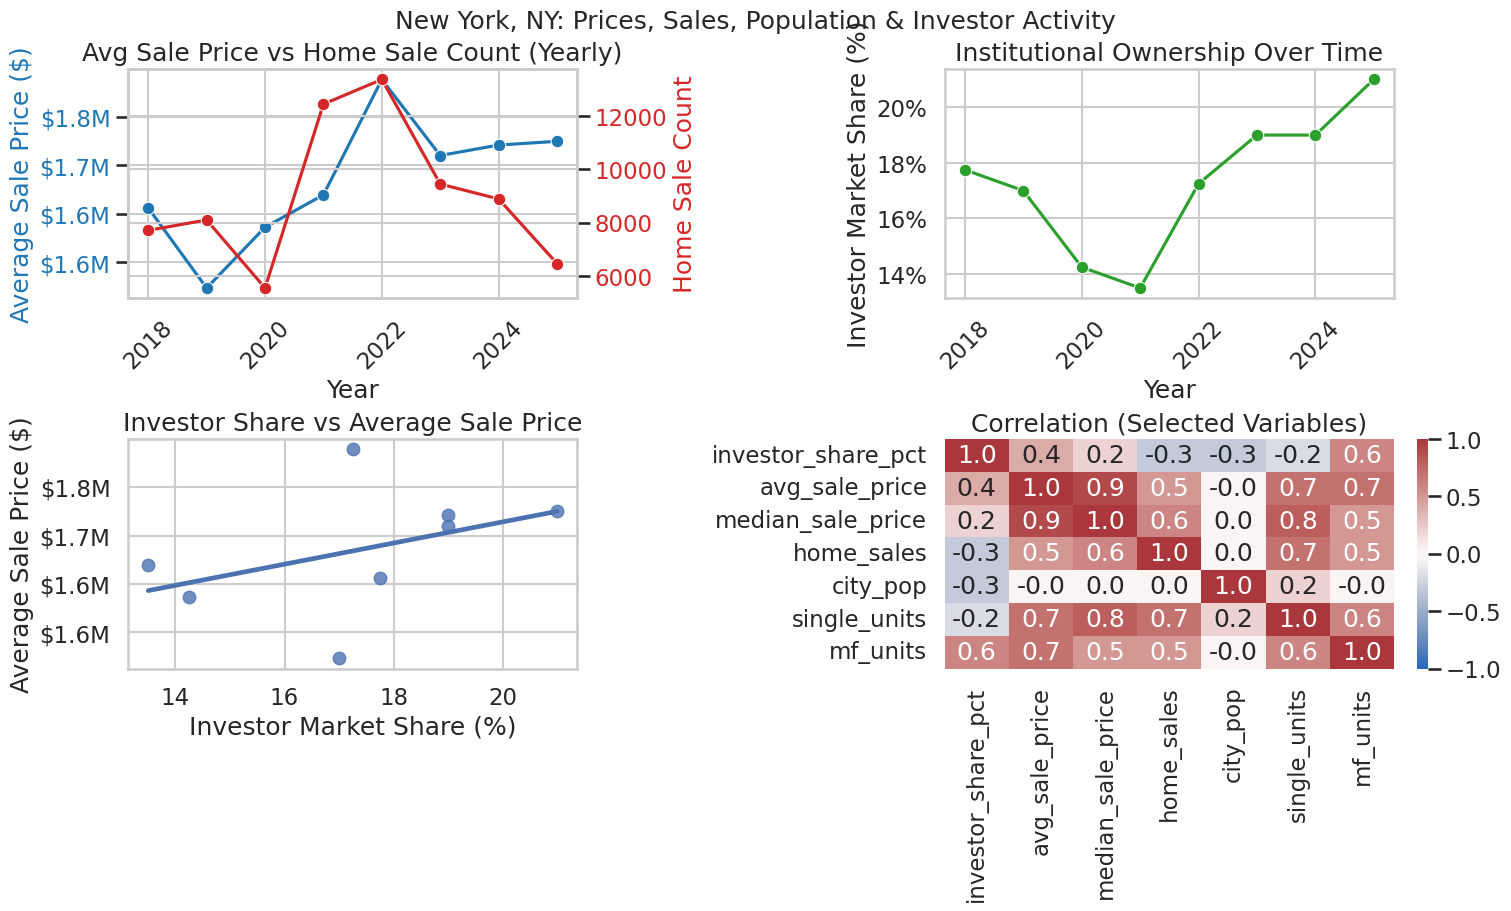

In [ ]:
_ = plot_city_dashboard(df_ny_final)   # New York

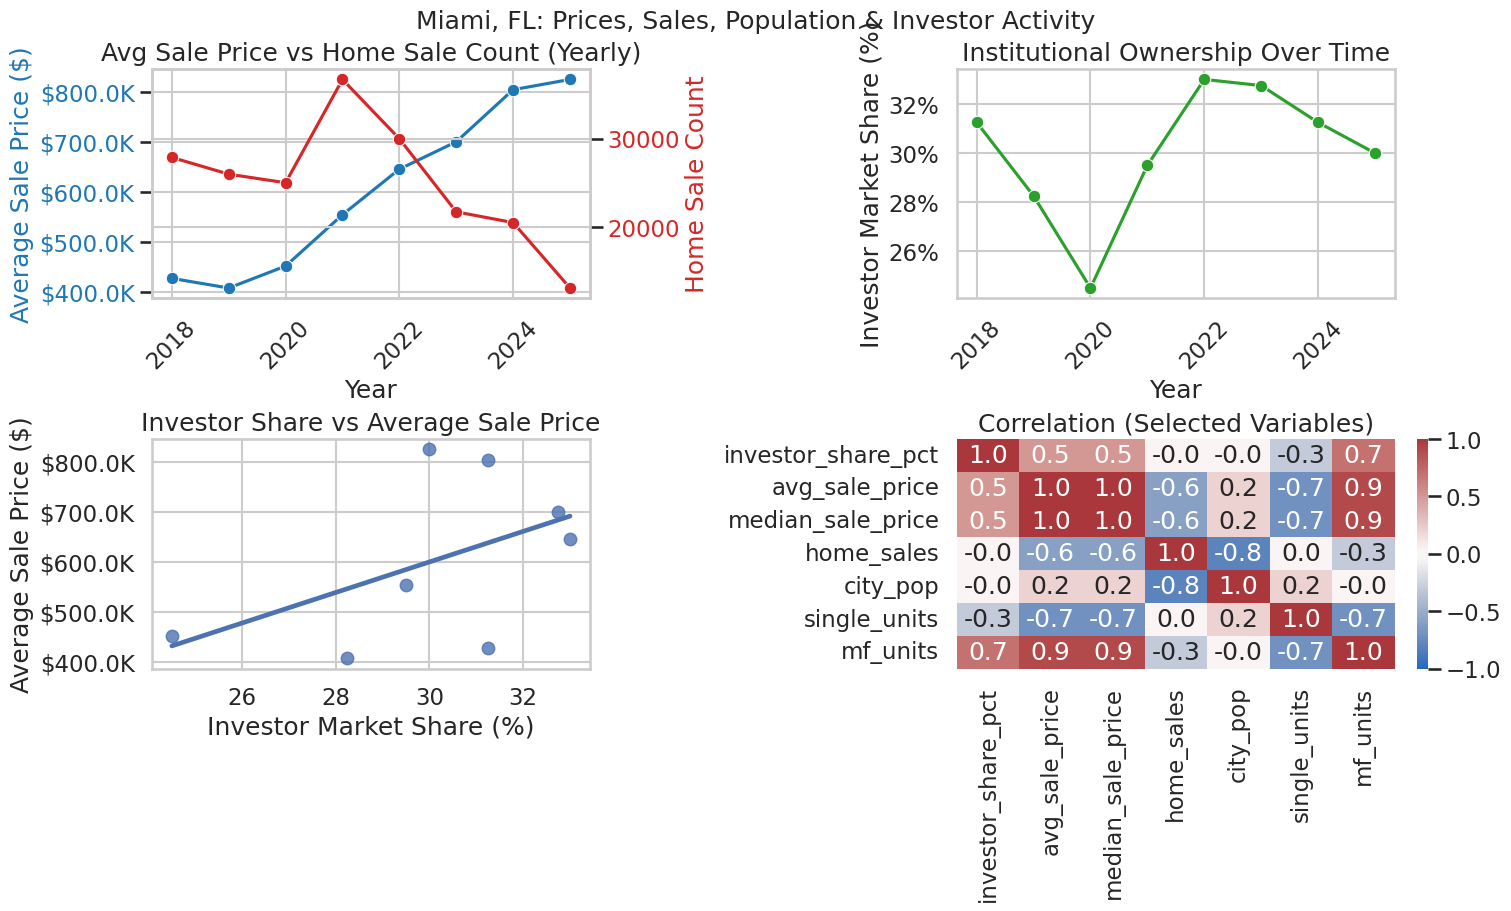

In [ ]:
_ = plot_city_dashboard(df_mia_final)  # Miami

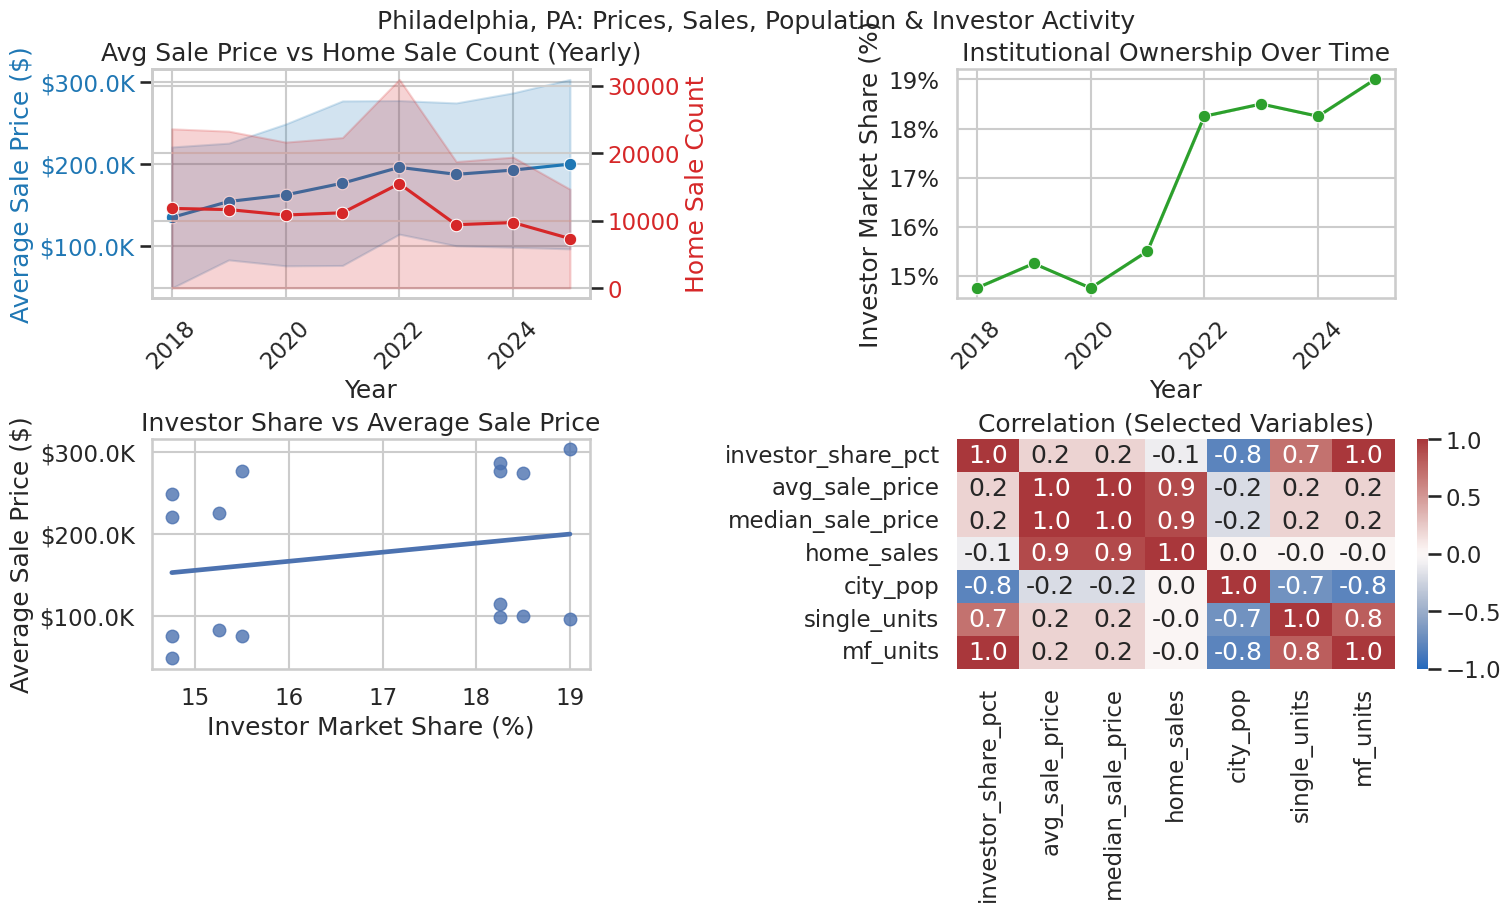

In [ ]:
_ = plot_city_dashboard(df_pa_final)   # Philadelphia